# 情感分析及数据集
:label:`sec_sentiment`

随着在线社交媒体和评论平台的快速发展，大量评论的数据被记录下来。这些数据具有支持决策过程的巨大潜力。
*情感分析*（sentiment analysis）研究人们在文本中
（如产品评论、博客评论和论坛讨论等）“隐藏”的情绪。
它在广泛应用于政治（如公众对政策的情绪分析）、
金融（如市场情绪分析）和营销（如产品研究和品牌管理）等领域。

由于情感可以被分类为离散的极性或尺度（例如，积极的和消极的），我们可以将情感分析看作一项文本分类任务，它将可变长度的文本序列转换为固定长度的文本类别。在本章中，我们将使用斯坦福大学的[大型电影评论数据集（large movie review dataset）](https://ai.stanford.edu/~amaas/data/sentiment/)进行情感分析。它由一个训练集和一个测试集组成，其中包含从IMDb下载的25000个电影评论。在这两个数据集中，“积极”和“消极”标签的数量相同，表示不同的情感极性。


In [1]:
import os
import torch
from torch import nn
# from d2l import torch as d2l

##  读取数据集

首先，下载并提取路径`../data/aclImdb`中的IMDb评论数据集。


In [2]:
import os
import torch
import requests
import zipfile
import tarfile
import hashlib
from io import BytesIO

#@save
DATA_HUB = {}
def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

In [5]:
DATA_HUB = {}
DATA_HUB['aclImdb'] = (
    'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz',
    '01ada507287d82875905620988597833ad4e0903')

data_dir = download_extract('aclImdb', 'aclImdb')

接下来，读取训练和测试数据集。每个样本都是一个评论及其标签：1表示“积极”，0表示“消极”。


In [6]:
#@save
def read_imdb(data_dir, is_train):
    """读取IMDb评论数据集文本序列和标签"""
    data, labels = [], []
    for label in ('pos', 'neg'):
        folder_name = os.path.join(data_dir, 'train' if is_train else 'test',
                                   label)
        for file in os.listdir(folder_name):
            with open(os.path.join(folder_name, file), 'rb') as f:
                review = f.read().decode('utf-8').replace('\n', '')
                data.append(review)
                labels.append(1 if label == 'pos' else 0)
    return data, labels

train_data = read_imdb(data_dir, is_train=True)
print('训练集数目：', len(train_data[0]))
for x, y in zip(train_data[0][:3], train_data[1][:3]):
    print('标签：', y, 'review:', x[0:60])

训练集数目： 25000
标签： 1 review: Bromwell High is a cartoon comedy. It ran at the same time a
标签： 1 review: Homelessness (or Houselessness as George Carlin stated) has 
标签： 1 review: Brilliant over-acting by Lesley Ann Warren. Best dramatic ho


## 预处理数据集

将每个单词作为一个词元，过滤掉出现不到5次的单词，我们从训练数据集中创建一个词表。


In [8]:
def tokenize(lines, token='word'):  #@save
    """将文本行拆分为单词或字符词元"""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('错误：未知词元类型：' + token)


import collections
import torch

class Vocab:  #@save
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # 未知词元的索引为0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # 未知词元的索引为0
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs
    
def count_corpus(tokens):  #@save
    """统计词元的频率"""
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元列表展平成一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [9]:
train_tokens = tokenize(train_data[0], token='word')
vocab = Vocab(train_tokens, min_freq=5, reserved_tokens=['<pad>'])

在词元化之后，让我们绘制评论词元长度的直方图。


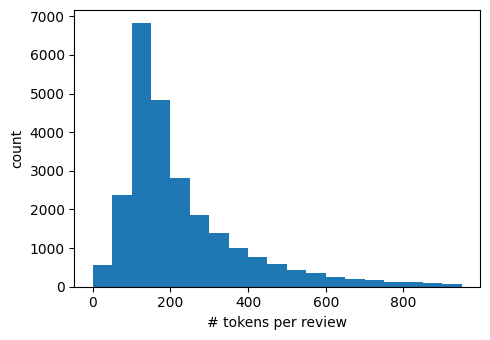

In [10]:
import matplotlib.pyplot as plt

# 设置图形大小并绘制直方图
fig, ax = plt.subplots(figsize=(5, 3.5))
ax.set_xlabel('# tokens per review')
ax.set_ylabel('count')
ax.hist([len(line) for line in train_tokens], bins=range(0, 1000, 50))
plt.tight_layout()
plt.show()

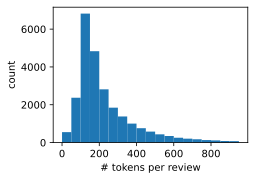

In [5]:
d2l.set_figsize()
d2l.plt.xlabel('# tokens per review')
d2l.plt.ylabel('count')
d2l.plt.hist([len(line) for line in train_tokens], bins=range(0, 1000, 50));

正如我们所料，评论的长度各不相同。为了每次处理一小批量这样的评论，我们通过截断和填充将每个评论的长度设置为500。这类似于 :numref:`sec_machine_translation`中对机器翻译数据集的预处理步骤。


In [11]:
def truncate_pad(line, num_steps, padding_token):
    """截断或填充文本序列"""
    if len(line) > num_steps:
        return line[:num_steps]  # 截断
    return line + [padding_token] * (num_steps - len(line))  # 填充

In [12]:
num_steps = 500  # 序列长度
train_features = torch.tensor([truncate_pad(
    vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
print(train_features.shape)

torch.Size([25000, 500])


## 创建数据迭代器

现在我们可以创建数据迭代器了。在每次迭代中，都会返回一小批量样本。


In [13]:
from torch.utils import data

def load_array(data_arrays, batch_size, is_train=True):  #@save
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [14]:
train_iter = load_array((train_features,
    torch.tensor(train_data[1])), 64)

for X, y in train_iter:
    print('X:', X.shape, ', y:', y.shape)
    break
print('小批量数目：', len(train_iter))

X: torch.Size([64, 500]) , y: torch.Size([64])
小批量数目： 391


## 整合代码

最后，我们将上述步骤封装到`load_data_imdb`函数中。它返回训练和测试数据迭代器以及IMDb评论数据集的词表。


In [15]:
#@save
def load_data_imdb(batch_size, num_steps=500):
    """返回数据迭代器和IMDb评论数据集的词表"""
    data_dir = download_extract('aclImdb', 'aclImdb')
    train_data = read_imdb(data_dir, True)
    test_data = read_imdb(data_dir, False)
    train_tokens = tokenize(train_data[0], token='word')
    test_tokens = tokenize(test_data[0], token='word')
    vocab = Vocab(train_tokens, min_freq=5)
    train_features = torch.tensor([truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
    test_features = torch.tensor([truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in test_tokens])
    train_iter = load_array((train_features, torch.tensor(train_data[1])),
                                batch_size)
    test_iter = load_array((test_features, torch.tensor(test_data[1])),
                               batch_size,
                               is_train=False)
    return train_iter, test_iter, vocab

## 小结

* 情感分析研究人们在文本中的情感，这被认为是一个文本分类问题，它将可变长度的文本序列进行转换转换为固定长度的文本类别。
* 经过预处理后，我们可以使用词表将IMDb评论数据集加载到数据迭代器中。

## 练习

1. 我们可以修改本节中的哪些超参数来加速训练情感分析模型？
1. 请实现一个函数来将[Amazon reviews](https://snap.stanford.edu/data/web-Amazon.html)的数据集加载到数据迭代器中进行情感分析。


[Discussions](https://discuss.d2l.ai/t/5726)
